In [ ]:
# Importing Libraries and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize

# Load data
# List of stock tickers
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "NFLX", "INTC", "AMD", "IBM"]

# Fetch historical data
data = yf.download(tickers, start="2014-01-01", end="2024-01-01")['Adj Close']

# Display the first few rows of data
data.head()

[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,AMD,AMZN,GOOGL,IBM,INTC,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,,,,
2014-01-02 00:00:00+00:00,17.253256,3.95,19.898500,27.787050,113.390991,19.178791,54.545769,31.120743,51.831429,0.373992,10.006667
2014-01-03 00:00:00+00:00,16.874279,4.00,19.822001,27.584349,114.069389,19.171358,54.396221,30.911373,51.871429,0.369512,9.970667
2014-01-06 00:00:00+00:00,16.966295,4.13,19.681499,27.891895,113.678223,18.933386,57.028294,30.258133,51.367142,0.374464,9.800000
2014-01-07 00:00:00+00:00,16.844957,4.18,19.901501,28.429604,115.945686,19.030062,57.746132,30.492620,48.500000,0.380595,9.957333
2014-01-08 00:00:00+00:00,16.951628,4.18,20.096001,28.488768,114.882210,18.911077,58.055199,29.948261,48.712856,0.385782,10.085333


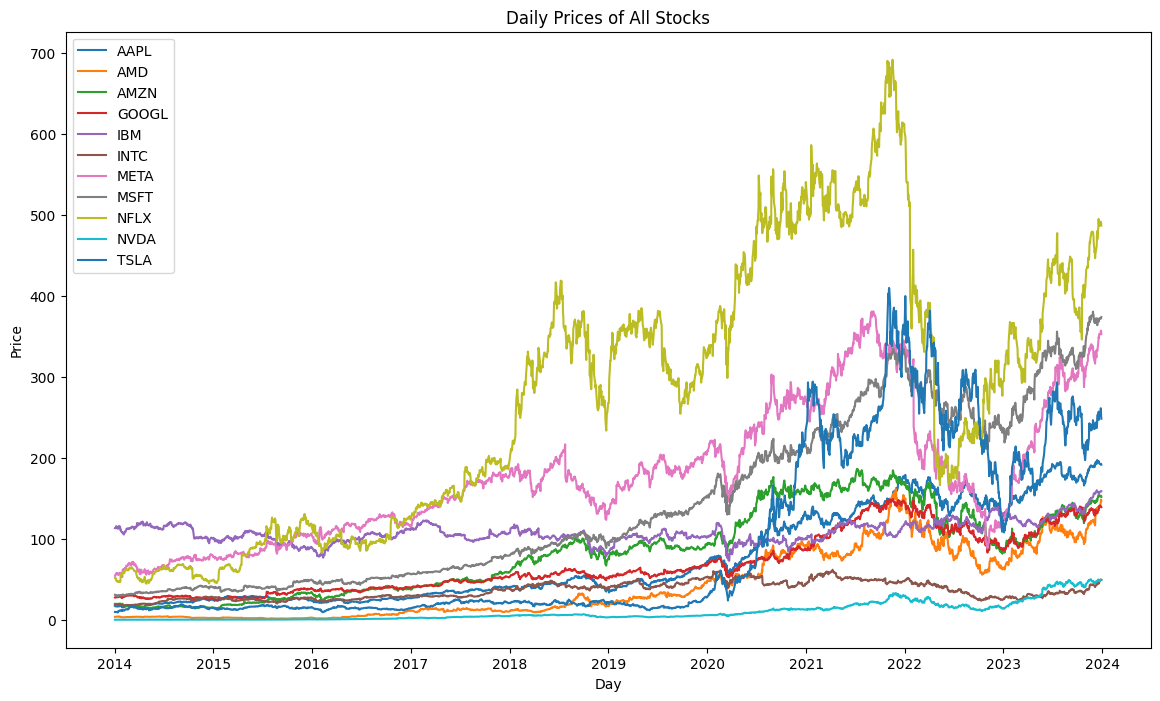

In [35]:
# 1. Plotting Daily Prices of All Stocks
plt.figure(figsize=(14, 8))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)
plt.title('Daily Prices of All Stocks')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.show()

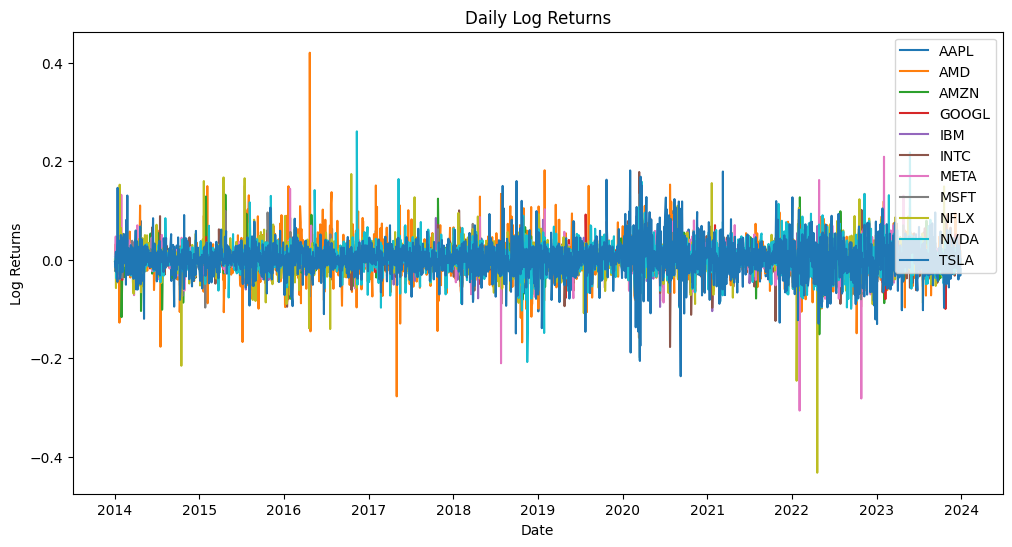

In [36]:
# 2. Calculate daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Plot Daily Log Returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns)
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend(log_returns.columns, loc='upper right')
plt.show()

In [37]:
# 3. Covariance and Correlation Tables
cov_matrix = log_returns.cov() * 252  # Annualizing covariance matrix
corr_matrix = log_returns.corr()
cov_matrix

Ticker,AAPL,AMD,AMZN,GOOGL,IBM,INTC,META,MSFT,NFLX,NVDA,TSLA
Ticker,,,,,,,,,,,
AAPL,0.080610,0.068365,0.051094,0.047866,0.027133,0.047891,0.056362,0.051705,0.051831,0.073212,0.066629
AMD,0.068365,0.327367,0.076423,0.062022,0.037585,0.073426,0.075828,0.065763,0.084174,0.155286,0.109582
AMZN,0.051094,0.076423,0.109628,0.059403,0.022430,0.044242,0.072627,0.055603,0.075382,0.078198,0.073748
GOOGL,0.047866,0.062022,0.059403,0.077502,0.026323,0.045316,0.067822,0.053861,0.057313,0.071260,0.060168
IBM,0.027133,0.037585,0.022430,0.026323,0.054692,0.034513,0.023447,0.028516,0.018273,0.035003,0.027898
INTC,0.047891,0.073426,0.044242,0.045316,0.034513,0.106382,0.052858,0.051328,0.050903,0.077343,0.060064
META,0.056362,0.075828,0.072627,0.067822,0.023447,0.052858,0.143057,0.057594,0.077595,0.084322,0.073703
MSFT,0.051705,0.065763,0.055603,0.053861,0.028516,0.051328,0.057594,0.073179,0.054460,0.076449,0.061836
NFLX,0.051831,0.084174,0.075382,0.057313,0.018273,0.050903,0.077595,0.054460,0.204474,0.086130,0.088448


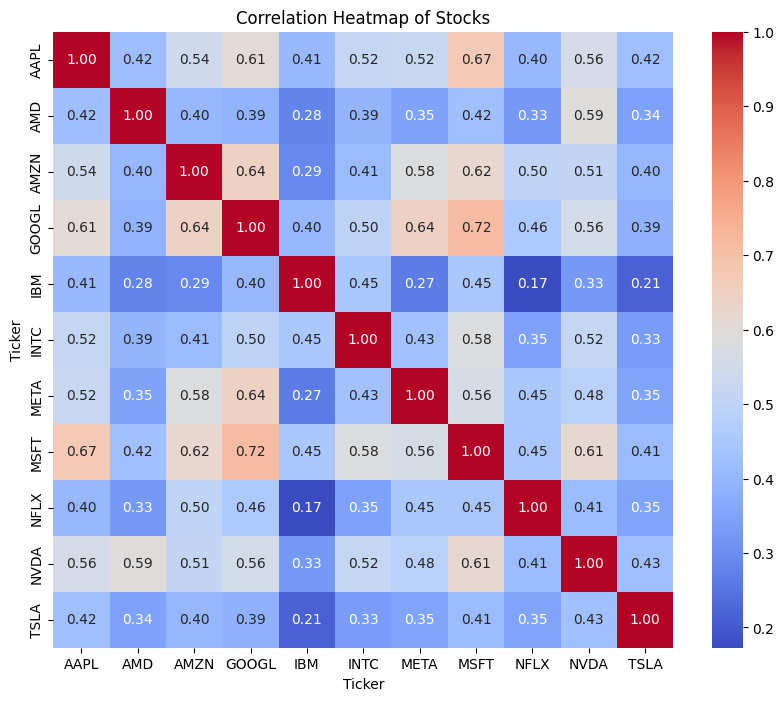

In [38]:
# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Stocks")
plt.show()

In [39]:
# 5. Portfolio Optimization Functions
def portfolio_stats(weights):
    weights = np.array(weights)
    port_return = np.sum(log_returns.mean() * weights) * 252  # Annualizing returns
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Using annualized covariance matrix
    return {'return': port_return, 'risk': port_risk, 'sharpe': port_return / port_risk}

# Optimization functions
def minimize_sharpe(weights): return -portfolio_stats(weights)['sharpe']
def minimize_risk(weights): return portfolio_stats(weights)['risk']

num_assets = len(log_returns.columns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Optimal portfolio for Maximum Sharpe Ratio
optimal_sharpe = minimize(minimize_sharpe, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)

# Minimum Risk Portfolio
optimal_risk = minimize(minimize_risk, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)

In [40]:
# 6. Target Return Portfolio for Efficient Frontier
def target_return_optimization(target):
    def portfolio_for_target(weights): return (portfolio_stats(weights)['return'] - target) ** 2
    result = minimize(portfolio_for_target, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)
    return result

In [41]:
# Generating Efficient Frontier by Varying Target Returns
target_returns = np.linspace(0, portfolio_stats(optimal_sharpe.x)['return'] + 0.1, 100)
minimal_risks = []
for target in target_returns:
    def target_return_constraint(weights):
        return portfolio_stats(weights)['return'] - target
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'eq', 'fun': target_return_constraint})
    optimized = minimize(minimize_risk, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)
    minimal_risks.append(optimized.fun if optimized.success else np.nan)

minimal_risks = np.array(minimal_risks)

In [42]:
# 8. Monte Carlo Simulation for Random Portfolios
num_portfolios = 5000
portfolio_risks = []
portfolio_returns = []
for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    stats = portfolio_stats(weights)
    portfolio_risks.append(stats['risk'])
    portfolio_returns.append(stats['return'])

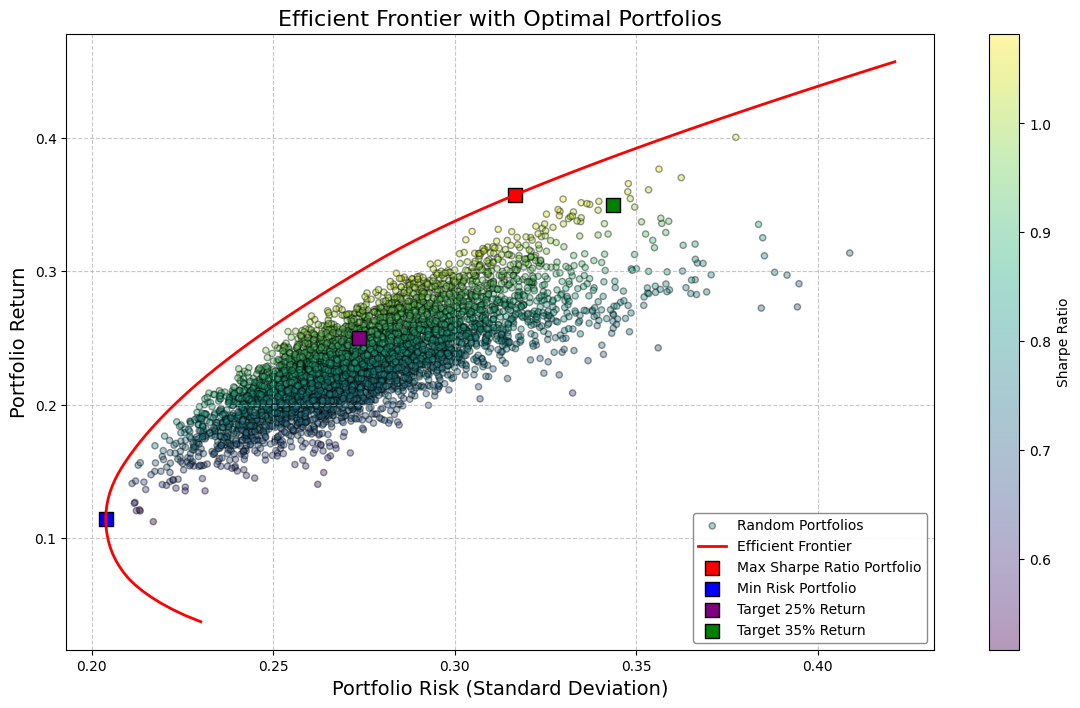

In [43]:
# 9. Final Plot with Efficient Frontier and Portfolio Points
plt.figure(figsize=(14, 8))

# Scatter plot of simulated portfolios
scatter = plt.scatter(portfolio_risks, portfolio_returns, c=np.array(portfolio_returns) / np.array(portfolio_risks),
                      marker='o', alpha=0.4, edgecolor='k', s=20, cmap='viridis', label='Random Portfolios')
plt.colorbar(scatter, label='Sharpe Ratio')

# Efficient Frontier Line
plt.plot(minimal_risks, target_returns, color='red', linestyle='-', linewidth=2, label='Efficient Frontier')

# Optimal portfolios with different markers for clarity
plt.scatter(portfolio_stats(optimal_sharpe.x)['risk'], portfolio_stats(optimal_sharpe.x)['return'],
            color='red', edgecolors='black', marker='s', s=100, label='Max Sharpe Ratio Portfolio')
plt.scatter(portfolio_stats(optimal_risk.x)['risk'], portfolio_stats(optimal_risk.x)['return'],
            color='blue', edgecolors='black', marker='s', s=100, label='Min Risk Portfolio')

# Target portfolios as squares at specific return levels
for target, color, label in zip([0.25, 0.35], ['purple', 'green'], ['25% Return', '35% Return']):
    weights = target_return_optimization(target).x
    plt.scatter(portfolio_stats(weights)['risk'], portfolio_stats(weights)['return'],
                color=color, edgecolors='black', marker='s', s=100, label=f'Target {label}')

# Final Plot Labels and Title
plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=14)
plt.ylabel('Portfolio Return', fontsize=14)
plt.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray')
plt.title('Efficient Frontier with Optimal Portfolios', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

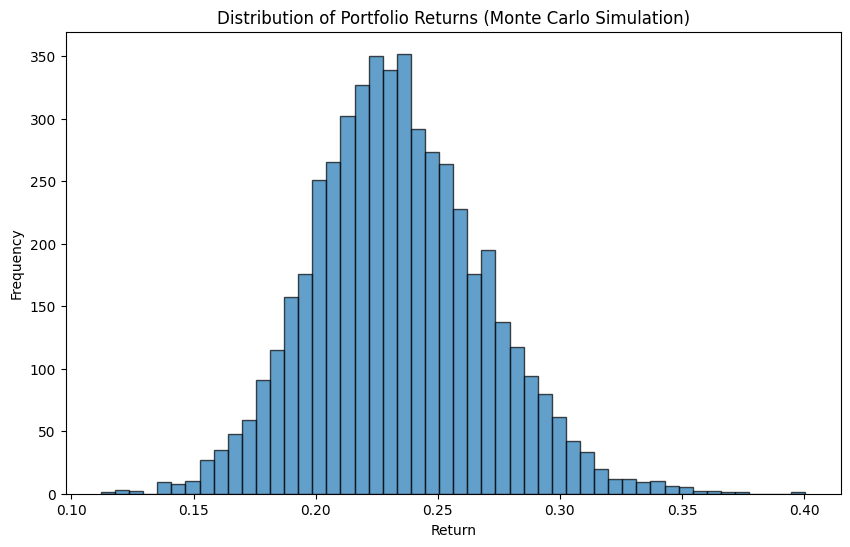

In [44]:
# 10. Histogram of Portfolio Returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Portfolio Returns (Monte Carlo Simulation)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()